梯度提升树模型中使用的基学习器被限定为CART回归树\
GBDT 回归、分类都可 用损失函数的负梯度拟合残差\
实例——GBDT用于获取高阶组合特征

GBDT优缺点
- 优点：\
      1、预测准确率相对较高；\
      2、由于制定CART作为基学习器，因此既可以处理标称型数据，又可以处理标量型数据；\
      3、在处理回归问题时，由于可以选择Huber损失函数或Quantile损失函数，因此相对于AdaBoost而言，对噪声的敏感性大大降低\
- 缺点：和AdaBoost一样，各个基学习器之间存在强关联，不利于做并行化处理

In [2]:
from sklearn.datasets import make_hastie_10_2
X,y = make_hastie_10_2(random_state=0)
print(X.shape,y.shape)
print(y[:10])

(12000, 10) (12000,)
[ 1. -1.  1. -1.  1. -1. -1. -1.  1. -1.]


In [3]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) # 按照8:2划分数据集
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(9600, 10) (9600,) (2400, 10) (2400,)


In [5]:
# 直接使用GBDT模型进行训练和验证，这里采用50棵树
from sklearn.ensemble import GradientBoostingClassifier
gbdt_clf = GradientBoostingClassifier(n_estimators=50)
gbdt_clf.fit(X_train,y_train)
y_predict = gbdt_clf.predict(X_test)
y_predict_prob = gbdt_clf.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
print("查准率、查全率、F1值：")
print(classification_report(y_test,y_predict,target_names=None))

print("AUC值：")
print(roc_auc_score(y_test,y_predict_prob))

print("混淆矩阵：")
print(confusion_matrix(y_test,y_predict,labels=None))

# 迭代后模型整体损失函数的值列表
print(gbdt_clf.train_score_)

查准率、查全率、F1值：
              precision    recall  f1-score   support

        -1.0       0.85      0.93      0.89      1179
         1.0       0.93      0.84      0.88      1221

    accuracy                           0.88      2400
   macro avg       0.89      0.88      0.88      2400
weighted avg       0.89      0.88      0.88      2400

AUC值：
0.9606678156296478
混淆矩阵：
[[1098   81]
 [ 198 1023]]
[1.36953271 1.353649   1.33812792 1.3235916  1.30937255 1.2957747
 1.281611   1.26784287 1.25525444 1.24267351 1.22994024 1.2177831
 1.20586004 1.19375881 1.18226144 1.17074567 1.16007415 1.14917147
 1.13889777 1.12912166 1.11917454 1.1090483  1.09929887 1.08997933
 1.08052826 1.070609   1.06144261 1.05213995 1.04366323 1.03584895
 1.02686602 1.01907101 1.01134662 1.00382127 0.99608245 0.98808495
 0.98015155 0.97271336 0.96585354 0.95870723 0.95136657 0.94383502
 0.93754931 0.9307964  0.92420758 0.9178307  0.91069783 0.90450459
 0.89862914 0.89230516]


In [9]:
# 获取训练集和验证集经过GBDT模型后的高阶组合特征
print(gbdt_clf.apply(X_train).shape)
print(gbdt_clf.apply(X_test).shape)

X_train_new = gbdt_clf.apply(X_train)[:,:,0]
X_test_new = gbdt_clf.apply(X_test)[:,:,0]
print(X_train_new.shape,X_test_new.shape)
print(X_train_new)
print(X_test_new)


(9600, 50, 1)
(2400, 50, 1)
(9600, 50) (2400, 50)
[[11. 10.  4. ...  3.  6.  4.]
 [11. 13.  4. ...  7.  7.  7.]
 [11. 14.  4. ...  7.  6.  7.]
 ...
 [11. 10.  4. ...  7.  6.  7.]
 [11. 14.  4. ...  7.  6.  7.]
 [11. 10.  4. ...  7.  6.  7.]]
[[11. 10.  7. ...  7.  6.  4.]
 [11. 10.  4. ...  7.  4.  7.]
 [11. 10.  4. ... 10.  6.  7.]
 ...
 [11. 10.  4. ...  4.  6.  7.]
 [ 7. 10.  4. ...  4.  6.  7.]
 [11.  3.  4. ...  7.  6.  7.]]


In [10]:
# 对GBDT模型输出的训练集和验证集的高阶特征进行 one-hot 编码
from sklearn.preprocessing import OneHotEncoder
grd_enc = OneHotEncoder() # 调用 one-hot 编码器
grd_enc.fit(X_train_new) # fit one-hot 编码器

# 对GBDT模型输出的训练集特征和验证集高阶特征进行one-hot编码
X_train_onehot = grd_enc.transform(X_train_new) # 训练集
X_test_onehot = grd_enc.transform(X_test_new) # 验证集
print(X_train_onehot.shape,X_test_onehot.shape)

(9600, 400) (2400, 400)


In [14]:
X_train_onehot

<9600x400 sparse matrix of type '<class 'numpy.float64'>'
	with 480000 stored elements in Compressed Sparse Row format>

In [15]:
# 用 one-hot编码后的训练集训练LR模型，并在验证集上验证
from sklearn.linear_model import LogisticRegression
LR_clf = LogisticRegression()
LR_clf.fit(X_train_onehot,y_train)

# 用训练好的LR模型对one-hot编码后的X_test进行预测
y_predict = LR_clf.predict(X_test_onehot)
y_predict_prob = LR_clf.predict_proba(X_test_onehot)[:,1]


C:\Users\DLadmin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
# 输出LR模型对验证集的预测结果
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
print("查准率、查全率、F1值：")
print(classification_report(y_test,y_predict,target_names=None))
print("AUC值：")
print(roc_auc_score(y_test,y_predict_prob))
print("混淆矩阵：")
print(confusion_matrix(y_test,y_predict,labels=None))

查准率、查全率、F1值：
              precision    recall  f1-score   support

        -1.0       0.91      0.91      0.91      1179
         1.0       0.91      0.91      0.91      1221

    accuracy                           0.91      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.91      0.91      0.91      2400

AUC值：
0.9720143460601476
混淆矩阵：
[[1068  111]
 [ 111 1110]]


GBRT与线性回归的比较

In [20]:
# 波士顿房价数据
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
print(X.shape,y.shape)
print(X[:2])

(442, 10) (442,)
[[ 0.03807591  0.05068012  0.06169621  0.02187239 -0.0442235  -0.03482076
  -0.04340085 -0.00259226  0.01990749 -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 -0.02632753 -0.00844872 -0.01916334
   0.07441156 -0.03949338 -0.06833155 -0.09220405]]


In [21]:
# 划分数据集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7)

# 数据标准化
from sklearn import preprocessing
standard_X = preprocessing.StandardScaler()
X_train = standard_X.fit_transform(X_train)
X_test = standard_X.transform(X_test)
standard_y = preprocessing.StandardScaler()
y_train = standard_y.fit_transform(y_train.reshape(-1,1))
y_test = standard_y.transform(y_test.reshape(-1,1))

In [ ]:
# 使用弹性网络回归模型
from sklearn.linear_model import ElasticNet
ElasticNet_clf = ElasticNet(alpha=0.001,l1_ratio=0.01,random_state=0) # 多次尝试后最好结果是0.5588
ElasticNet_clf.fit(X_train,y_train.ravel())
ElasticNet_clf_result = ElasticNet_clf.predict(X_test)
ElasticNet_clf_score = ElasticNet_clf.score(X_test,y_test.ravel())
print("ElasticNet模型得分：",ElasticNet_clf_score)

ElasticNet模型得分： 0.5588292025328949


In [ ]:
# 使用GBRT模型
from sklearn.ensemble import GradientBoostingRegressor
GBRT_clf = GradientBoostingRegressor(learning_rate=0.1,max_depth=9,max_features=0.2,
                                      min_samples_leaf=24,n_estimators=60,random_state=0) # 多次试验后最好结果是0.5604
GBRT_clf.fit(X_train,y_train.ravel())
GBRT_clf_result = GBRT_clf.predict(X_test)
GBRT_clf_score = GBRT_clf.score(X_test,y_test.ravel())
print("GBRT模型得分：",GBRT_clf_score)

GBRT模型得分： 0.5604431482229271


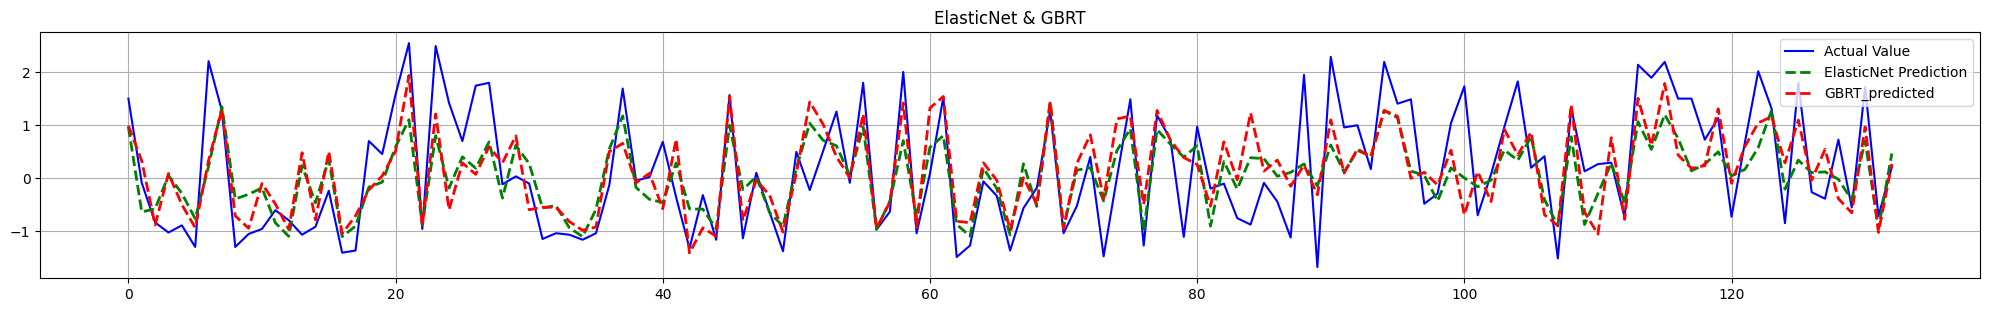

In [26]:
# 画图对比
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,3))
axes = fig.add_subplot(1,1,1)
line1, = axes.plot(range(len(y_test)),y_test,'b',label = "Actual Value")
line2, = axes.plot(range(len(ElasticNet_clf_result)),ElasticNet_clf_result,'g--',label = "ElasticNet Prediction",linewidth=2)
line3, = axes.plot(range(len(GBRT_clf_result)),GBRT_clf_result,'r--',label="GBRT_predicted",linewidth=2)
axes.grid()
fig.tight_layout()
plt.legend(handles=[line1,line2,line3])
plt.title("ElasticNet & GBRT")
plt.show()